## 解决方案思路
* 赛题要求是资金的流入流出预测，即申购和赎回的预测，所以基于最基本的total_purchase_amt、total_redeem_amt字段进行预测
* 方法1：采用时间序列进行预测
    * Step1，平稳性检测 adfuller
    * Step2，采用 ARIMA模型
    * Step3，模型训练集与预测
* 方法2：基于时序规则的挖掘
    * Step1，获得周期因子（weekday）
    * Step2，计算base
    * Step3，使用base * 周期因子进行预测
* 方法3：基于方法1和方法2的结果进行融合

In [1]:
import pandas as pd

#数据加载
data = pd.read_csv('./user_balance_table.csv', parse_dates=['report_date'])
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840421 entries, 0 to 2840420
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              int64         
 1   report_date          datetime64[ns]
 2   tBalance             int64         
 3   yBalance             int64         
 4   total_purchase_amt   int64         
 5   direct_purchase_amt  int64         
 6   purchase_bal_amt     int64         
 7   purchase_bank_amt    int64         
 8   total_redeem_amt     int64         
 9   consume_amt          int64         
 10  transfer_amt         int64         
 11  tftobal_amt          int64         
 12  tftocard_amt         int64         
 13  share_amt            int64         
 14  category1            float64       
 15  category2            float64       
 16  category3            float64       
 17  category4            float64       
dtypes: datetime64[ns](1), float64(4), int64(13)
memory usage: 390.

In [3]:
total_balance = data.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
total_balance

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


In [4]:
purchase = total_balance[['total_purchase_amt']]
redeem = total_balance[['total_redeem_amt']]

In [5]:
redeem

,total_redeem_amt
report_date,
2013-07-01,5525022
2013-07-02,2554548
2013-07-03,5953867
2013-07-04,6410729
2013-07-05,2763587
...,...
2014-08-27,468164147
2014-08-28,297893861
2014-08-29,273756380


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


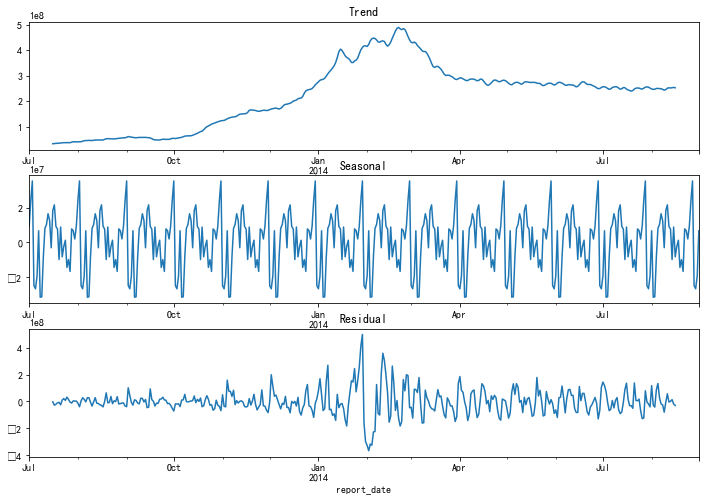

In [6]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 对指定区间范围内的数据可视化
def plot_stl(data):
    #STL返回三个部分 trend（趋势） seasonal（季节） residual（残差）
    result = sm.tsa.seasonal_decompose(data, period=30)
    #可视化
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    result.trend.plot(ax=ax1,title='Trend')
    result.seasonal.plot(ax=ax2,title='Seasonal')
    result.resid.plot(ax=ax3,title='Residual')
    
plot_stl(purchase.total_purchase_amt)

通过Trend图可以看出从三月份之后数据趋于稳定，所以可以去三月份之后的数据进行arima预测

In [7]:
purchase2 = purchase[(purchase.index >= '2014-04-01') & (purchase.index <= '2014-05-07')]
purchase2

,total_purchase_amt
report_date,
2014-04-01,453320585
2014-04-02,355347118
2014-04-03,363877120
2014-04-04,251895894
2014-04-05,202336542
2014-04-06,129477254
2014-04-07,196936223
2014-04-08,354770149
2014-04-09,383347565


([<matplotlib.axis.XTick at 0x1e3e152a0b8>,
 <a list of 37 Text major ticklabel objects>)

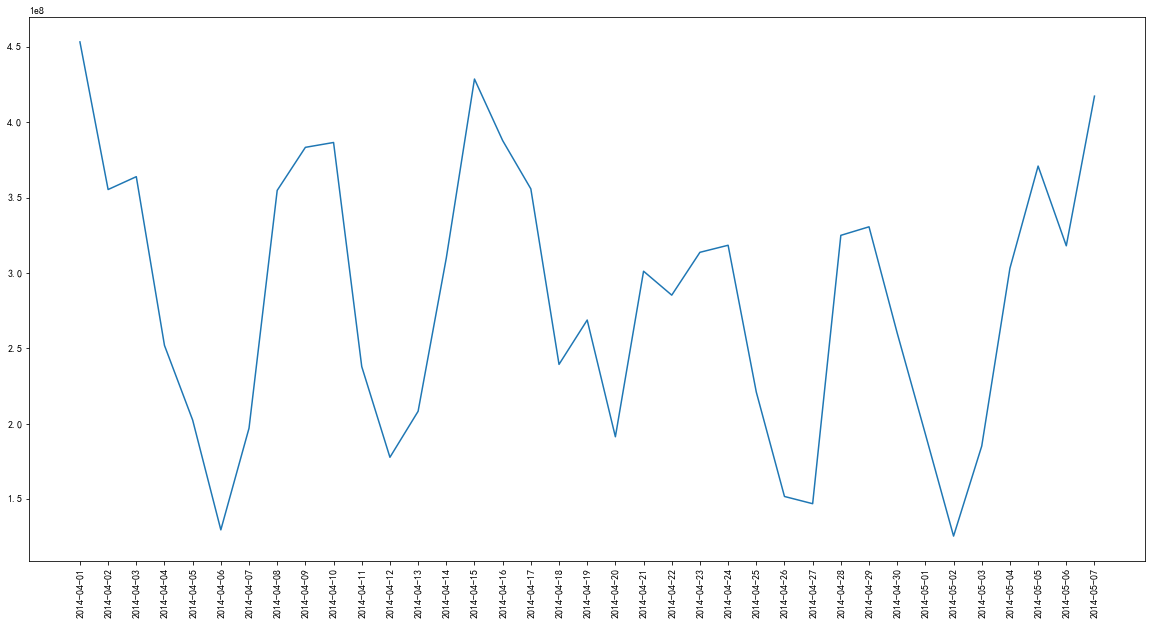

In [8]:
plt.figure(figsize=(20,10))
plt.plot(purchase2.total_purchase_amt)
#要看具体的每一天，可以加刻度
date_range = pd.date_range('2014-04-01','2014-05-07')
plt.xticks(date_range,rotation=90)

通过上图可知波谷都是节假日，波峰基本上是周初

In [9]:
from statsmodels.tsa.stattools import adfuller
#看时间序列的平稳性
t = adfuller(purchase['total_purchase_amt'])
t

(-1.5898802926313507,
 0.4886749751375928,
 18,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 15960.28197033403)

In [10]:
# 不能拒绝原假设（不平稳）
# 所以需要做差分(一阶)
diff1 = purchase.diff(1)

In [11]:
t = adfuller(diff1[1:])
t

(-7.947102224652354,
 3.1981868624879897e-12,
 18,
 407,
 {'1%': -3.4465195891135845,
  '5%': -2.8686676281678634,
  '10%': -2.5705668101226085},
 15918.844657651942)

In [12]:
t2 = adfuller(redeem['total_redeem_amt'])
t2
# 不能拒绝原假设（不平稳）
# 所以需要做差分(一阶)
diff2 = redeem.diff(1)

In [13]:
t2 = adfuller(diff2[1:])
t2

(-11.69198690696882,
 1.6443717458499181e-21,
 12,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15779.04993673871)

* 计算ARIMA模型最优参数

In [16]:
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from sklearn.model_selection import learning_curve,GridSearchCV
# p,d,q其中d=1

# 设置参数范围
ps = range(0, 10)
qs = range(0, 10)
ds = range(0, 1)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)
# 寻找最优ARIMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
i=1
for param in parameters_list:
    print('第{}次循环'.format(i))
    try:
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = ARIMA(purchase,order=(param[0], param[1], param[2])).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    i+=1
# 输出最优模型
print('最优模型: ', best_model.summary())



第1次循环
第2次循环
第3次循环
第4次循环
第5次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information w

第6次循环
第7次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第8次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第9次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第10次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第11次循环
第12次循环
第13次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第14次循环
第15次循环

C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



第16次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第17次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第18次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第19次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第20次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第21次循环
第22次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第23次循环
第24次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第25次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第26次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第27次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第28次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第29次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第30次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第31次循环
第32次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第33次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第34次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第35次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第36次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第37次循环
第38次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第39次循环
参数错误: (3, 0, 8)
第39次循环
参数错误: (3, 0, 9)
第39次循环
第40次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第41次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第42次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第43次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第44次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第45次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第46次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第47次循环
参数错误: (4, 0, 8)
第47次循环
参数错误: (4, 0, 9)
第47次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第48次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第49次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第50次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第51次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第52次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第53次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information wa

第54次循环
参数错误: (5, 0, 7)
第54次循环
参数错误: (5, 0, 8)
第54次循环
参数错误: (5, 0, 9)
第54次循环
第55次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第56次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第57次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第58次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第59次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第60次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第61次循环
参数错误: (6, 0, 7)
第61次循环
参数错误: (6, 0, 8)
第61次循环
参数错误: (6, 0, 9)
第61次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第62次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第63次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第64次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第65次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第66次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第67次循环
参数错误: (7, 0, 6)
第67次循环
参数错误: (7, 0, 7)
第67次循环
参数错误: (7, 0, 8)
第67次循环
参数错误: (7, 0, 9)
第67次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information w

第68次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第69次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第70次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第71次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第72次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第73次循环
参数错误: (8, 0, 6)
第73次循环
参数错误: (8, 0, 7)
第73次循环
参数错误: (8, 0, 8)
第73次循环
参数错误: (8, 0, 9)
第73次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information w

第74次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第75次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第76次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第77次循环
第78次循环


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


第79次循环
参数错误: (9, 0, 6)
第79次循环
参数错误: (9, 0, 7)
第79次循环
参数错误: (9, 0, 8)
第79次循环
参数错误: (9, 0, 9)


C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


最优模型:                                ARMA Model Results                              
Dep. Variable:     total_purchase_amt   No. Observations:                  427
Model:                     ARMA(9, 4)   Log Likelihood               -8332.745
Method:                       css-mle   S.D. of innovations       71737768.427
Date:                Mon, 30 Nov 2020   AIC                          16695.490
Time:                        15:37:10   BIC                          16756.342
Sample:                    07-01-2013   HQIC                         16719.525
                         - 08-31-2014                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.168e+08   9.58e+07      2.263      0.024    2.91e+07    4.05e+08
ar.L1.total_purchase_amt     2.1154      0.117     18.022      0.000       1.885  

In [17]:
model = ARIMA(purchase,order=(9,1,4)).fit()
# 使用typ='levels' 对原始数据维度上进行预测，相当于进行了反差分
purchase_pred = model.predict('2014-09-01','2014-09-30',typ='levels')
purchase_pred

C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2014-09-01    3.181209e+08
2014-09-02    3.281642e+08
2014-09-03    3.089999e+08
2014-09-04    2.572063e+08
2014-09-05    2.284246e+08
2014-09-06    2.045706e+08
2014-09-07    2.419994e+08
2014-09-08    2.836054e+08
2014-09-09    3.136331e+08
2014-09-10    3.005516e+08
2014-09-11    2.639080e+08
2014-09-12    2.312889e+08
2014-09-13    2.245305e+08
2014-09-14    2.548090e+08
2014-09-15    2.961682e+08
2014-09-16    3.220720e+08
2014-09-17    3.101161e+08
2014-09-18    2.726888e+08
2014-09-19    2.365145e+08
2014-09-20    2.287316e+08
2014-09-21    2.547156e+08
2014-09-22    2.947057e+08
2014-09-23    3.196762e+08
2014-09-24    3.110034e+08
2014-09-25    2.766563e+08
2014-09-26    2.426236e+08
2014-09-27    2.349973e+08
2014-09-28    2.594247e+08
2014-09-29    2.979944e+08
2014-09-30    3.224251e+08
Freq: D, dtype: float64

In [18]:
model.aic #越小越好

16655.15709270983

In [19]:
# p,d,q其中d=1
model2 = ARIMA(redeem,order=(9,1,4)).fit()
# 使用typ='levels' 对原始数据维度上进行预测，相当于进行了反差分
redeem_pred = model2.predict('2014-09-01','2014-09-30',typ='levels')
redeem_pred

C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.ex

2014-09-01    2.849093e+08
2014-09-02    3.107281e+08
2014-09-03    3.252729e+08
2014-09-04    2.970501e+08
2014-09-05    2.327450e+08
2014-09-06    2.048514e+08
2014-09-07    2.363191e+08
2014-09-08    2.883918e+08
2014-09-09    3.244628e+08
2014-09-10    3.308337e+08
2014-09-11    2.979443e+08
2014-09-12    2.489066e+08
2014-09-13    2.210997e+08
2014-09-14    2.429546e+08
2014-09-15    2.924717e+08
2014-09-16    3.348743e+08
2014-09-17    3.371792e+08
2014-09-18    3.023099e+08
2014-09-19    2.518969e+08
2014-09-20    2.274582e+08
2014-09-21    2.452222e+08
2014-09-22    2.957865e+08
2014-09-23    3.375856e+08
2014-09-24    3.433539e+08
2014-09-25    3.061767e+08
2014-09-26    2.578075e+08
2014-09-27    2.313834e+08
2014-09-28    2.508561e+08
2014-09-29    2.987885e+08
2014-09-30    3.430741e+08
Freq: D, dtype: float64

In [20]:
model2.aic #越小越好

16527.542872525803

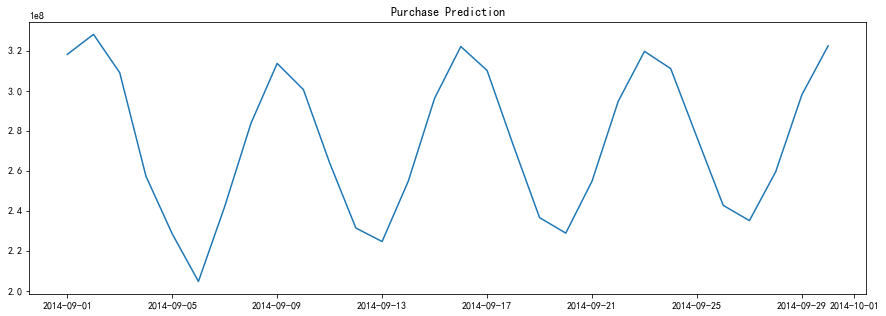

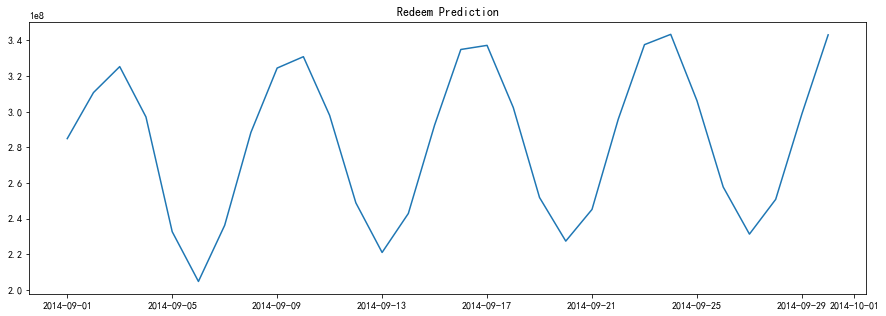

In [21]:
plt.figure(figsize=(15,5))
plt.title('Purchase Prediction')
plt.plot(purchase_pred)
plt.show()

plt.figure(figsize=(15,5))
plt.title('Redeem Prediction')
plt.plot(redeem_pred)
plt.show()

In [22]:
result = pd.DataFrame()
result['date'] = purchase_pred.index
result['purchase'] = purchase_pred.values
result['redeem'] = redeem_pred.values
result

,date,purchase,redeem
0,2014-09-01,3.181209e+08,2.849093e+08
1,2014-09-02,3.281642e+08,3.107281e+08
2,2014-09-03,3.089999e+08,3.252729e+08
3,2014-09-04,2.572063e+08,2.970501e+08
4,2014-09-05,2.284246e+08,2.327450e+08
5,2014-09-06,2.045706e+08,2.048514e+08
6,2014-09-07,2.419994e+08,2.363191e+08
7,2014-09-08,2.836054e+08,2.883918e+08
8,2014-09-09,3.136331e+08,3.244628e+08
9,2014-09-10,3.005516e+08,3.308337e+08


In [23]:
#将日期格式转换为预测结果提交要求的格式
result['date'] = result['date'].apply(lambda x:str(x).replace('-','')[0:8])
result

,date,purchase,redeem
0,20140901,3.181209e+08,2.849093e+08
1,20140902,3.281642e+08,3.107281e+08
2,20140903,3.089999e+08,3.252729e+08
3,20140904,2.572063e+08,2.970501e+08
4,20140905,2.284246e+08,2.327450e+08
5,20140906,2.045706e+08,2.048514e+08
6,20140907,2.419994e+08,2.363191e+08
7,20140908,2.836054e+08,2.883918e+08
8,20140909,3.136331e+08,3.244628e+08
9,20140910,3.005516e+08,3.308337e+08


In [24]:
result.to_csv('arima.csv',header=None,index=False)